# Préstamos
En la modalidad de préstamos en línea P2P no hay entrevista en persona y un prestatario
puede simplemente rellenar un formulario en línea y obtener la aprobación de un préstamo.
La información proporcionada únicamente por el prestatario es propensa a la exageración
y la distorsión. La mayor pregunta para toda empresa de préstamos P2P es si un usuario
incumplirá o no. El algoritmo para predecir la probabilidad de impago es el núcleo de un
negocio P2P y debe construirse con cuidado. Su tarea es construir un modelo de clasificación
para determinar si un usuario incumplirá su préstamo o no. Va a encontrar un conjunto de
datos llamado Lending_club_cleaned_2.csv donde encuentra diferentes variables que
describen a los prestatarios y al préstamo. Para este conjunto de datos:

a. Identifique una variable estrechamente relacionada con la probabilidad de impago y a partir de esta construya un modelo de regresión logística que permita
determinar dicha probabilidad.

b. Usualmente se quiere utilizar todos los datos disponibles para hacer predicciones.
Utilice todas las variables y construya un modelo de regresión logística multivariada
que permita predecir la probabilidad de impago.

c. Identifique las variables que mejoran la capacidad predictiva del modelo e
implemente un modelo tipo SVM para pronosticar la posibilidad de impago.

d. Implemente un modelo de redes neuronales tipo perceptrón multicapa que le
permita obtener la probabilidad de impago.

e. Determine cuál modelo genera un mejor desempeño


In [ ]:
#Montar unidad de drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Advertencias
import warnings
warnings.filterwarnings('ignore')
# Tratamiento de datos
import numpy as np
import pandas as pd
#Gráficos
import matplotlib.pyplot as plt
import seaborn as sb
# Preparación de datos
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn import set_config
# Modelado
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
# Evaluación
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Analisis de Decisiones/Taller1/Lending_club_cleaned_2.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38705 entries, 0 to 38704
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_status          38705 non-null  object 
 1   annual_inc           38705 non-null  float64
 2   verification_status  38705 non-null  object 
 3   emp_length           38705 non-null  object 
 4   home_ownership       38705 non-null  object 
 5   int_rate             38705 non-null  object 
 6   loan_amnt            38705 non-null  int64  
 7   purpose              38705 non-null  object 
 8   term                 38705 non-null  object 
 9   grade                38705 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.0+ MB


In [ ]:
# EXPLORACIÓN ESTADÍSTICA DE DATOS
data.describe()

,annual_inc,loan_amnt
count,3.870500e+04,38705.000000
mean,6.961750e+04,11303.916161
std,6.422378e+04,7470.319733
min,4.000000e+03,500.000000
25%,4.149600e+04,5500.000000
50%,6.000000e+04,10000.000000
75%,8.320000e+04,15000.000000
max,6.000000e+06,35000.000000


In [ ]:
data.describe(include = 'object')

,loan_status,verification_status,emp_length,home_ownership,int_rate,purpose,term,grade
count,38705,38705,38705,38705,38705,38705,38705,38705
unique,2,3,11,4,371,14,2,7
top,Fully Paid,Not Verified,10+ years,RENT,10.99%,debt_consolidation,36 months,B
freq,33265,16499,8899,18507,934,18275,28284,11697


In [ ]:
#En la variable int_rate existen 371 categorias?
data['int_rate']

0        10.65%
1        15.27%
2        15.96%
3        13.49%
4        12.69%
          ...  
38700     8.07%
38701    10.28%
38702     8.07%
38703     7.43%
38704    13.75%
Name: int_rate, Length: 38705, dtype: object

In [ ]:
# cambiaremos la variable de str a int para volverla una variable numerica
data['int_rate'] = data['int_rate'].str.replace('%','')
data['int_rate']= data.int_rate.astype('float64')

In [ ]:
data.describe()

,annual_inc,int_rate,loan_amnt
count,3.870500e+04,38705.000000,38705.000000
mean,6.961750e+04,12.059525,11303.916161
std,6.422378e+04,3.719517,7470.319733
min,4.000000e+03,5.420000,500.000000
25%,4.149600e+04,9.320000,5500.000000
50%,6.000000e+04,11.860000,10000.000000
75%,8.320000e+04,14.590000,15000.000000
max,6.000000e+06,24.590000,35000.000000


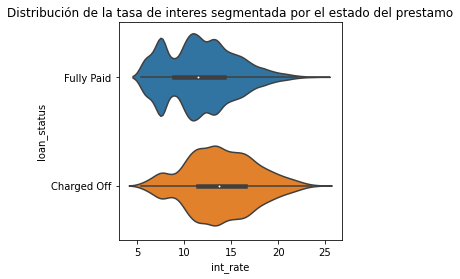

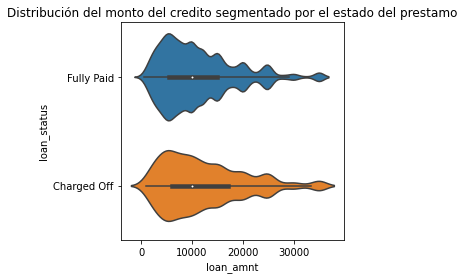

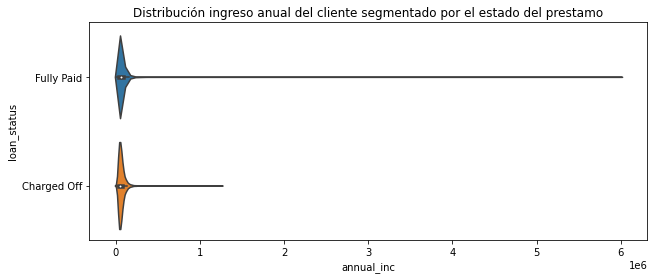

In [ ]:
# Gráfico de violin
fig, ax = plt.subplots(figsize = (4,4))
sb.violinplot(x = data['int_rate'], y = data['loan_status'], data = data, ax = ax)
ax.set_title('Distribución de la tasa de interes segmentada por el estado del prestamo')
fig, ax = plt.subplots(figsize = (4,4))
sb.violinplot(x = data['loan_amnt'], y = data['loan_status'], data = data, ax = ax)
ax.set_title('Distribución del monto del credito segmentado por el estado del prestamo')
fig, ax = plt.subplots(figsize = (10,4))
sb.violinplot(x = data['annual_inc'], y = data['loan_status'], data = data, ax = ax)
ax.set_title('Distribución ingreso anual del cliente segmentado por el estado del prestamo')
plt.show()

tal y como se ve en las graficas, solo hay datos atipicos en la variable annual_inc, en la cual tiene mucho sentido que los haya, por lo tanto no se borraran

## Preparación de datos

In [ ]:
numCols = data.select_dtypes(include = ['float64', 'int64']).columns.to_list()
matCols = data[['verification_status','home_ownership','term','grade']].columns.to_list()
ordCols =data[['emp_length','purpose','loan_status']].columns.tolist()

In [ ]:
numTransformer = Pipeline(steps = [('scaler',  MinMaxScaler())])
matTransformer = Pipeline(steps = [('onehot',  OneHotEncoder(handle_unknown = 'ignore'))])
ordTransformer = Pipeline(steps = [('ordinal', OrdinalEncoder(handle_unknown = 'error'))])

preproccesor = ColumnTransformer(transformers = [
    ('numeric', numTransformer, numCols),
    ('catOHE', matTransformer, matCols),
    ('CatOrd', ordTransformer, ordCols)
], remainder = 'passthrough')

set_config(display = 'diagram')
preproccesor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('scaler', MinMaxScaler())]),
                                 ['annual_inc', 'int_rate', 'loan_amnt']),
                                ('catOHE',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['verification_status', 'home_ownership',
                                  'term', 'grade']),
                                ('CatOrd',
                                 Pipeline(steps=[('ordinal',
                                                  OrdinalEncoder())]),
                                 ['emp_length', 'purpose', 'loan_status'])])

In [ ]:
dataPre = preproccesor.fit_transform(data)
dataPre

array([[3.33555704e-03, 2.72822118e-01, 1.30434783e-01, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [4.33622415e-03, 5.13823683e-01, 5.79710145e-02, ...,
        1.00000000e+01, 0.00000000e+00, 0.00000000e+00],
       [1.37625083e-03, 5.49817423e-01, 5.50724638e-02, ...,
        1.00000000e+00, 1.10000000e+01, 1.00000000e+00],
       ...,
       [1.60106738e-02, 1.38236828e-01, 1.30434783e-01, ...,
        1.00000000e+01, 2.00000000e+00, 1.00000000e+00],
       [3.26884590e-02, 1.04851330e-01, 1.30434783e-01, ...,
        1.00000000e+01, 9.00000000e+00, 1.00000000e+00],
       [3.00200133e-03, 4.34533125e-01, 2.02898551e-01, ...,
        1.00000000e+01, 2.00000000e+00, 1.00000000e+00]])

In [ ]:
dataPre.shape

(38705, 22)

In [ ]:
codCat = preproccesor.named_transformers_['catOHE']['onehot'].get_feature_names(matCols)
codCat

array(['verification_status_Not Verified',
       'verification_status_Source Verified',
       'verification_status_Verified', 'home_ownership_MORTGAGE',
       'home_ownership_OTHER', 'home_ownership_OWN',
       'home_ownership_RENT', 'term_ 36 months', 'term_ 60 months',
       'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F',
       'grade_G'], dtype=object)

In [ ]:
labels = np.concatenate([numCols, codCat, ordCols])
len(labels)

22

In [ ]:
dataPro = pd.DataFrame(dataPre, columns = labels)
dataPro.head()

,annual_inc,int_rate,loan_amnt,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,home_ownership_MORTGAGE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,...,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,emp_length,purpose,loan_status
0,0.003336,0.272822,0.130435,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
1,0.004336,0.513824,0.057971,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
2,0.001376,0.549817,0.055072,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,11.0,1.0
3,0.007538,0.420970,0.275362,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,9.0,1.0
4,0.012675,0.379238,0.072464,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0


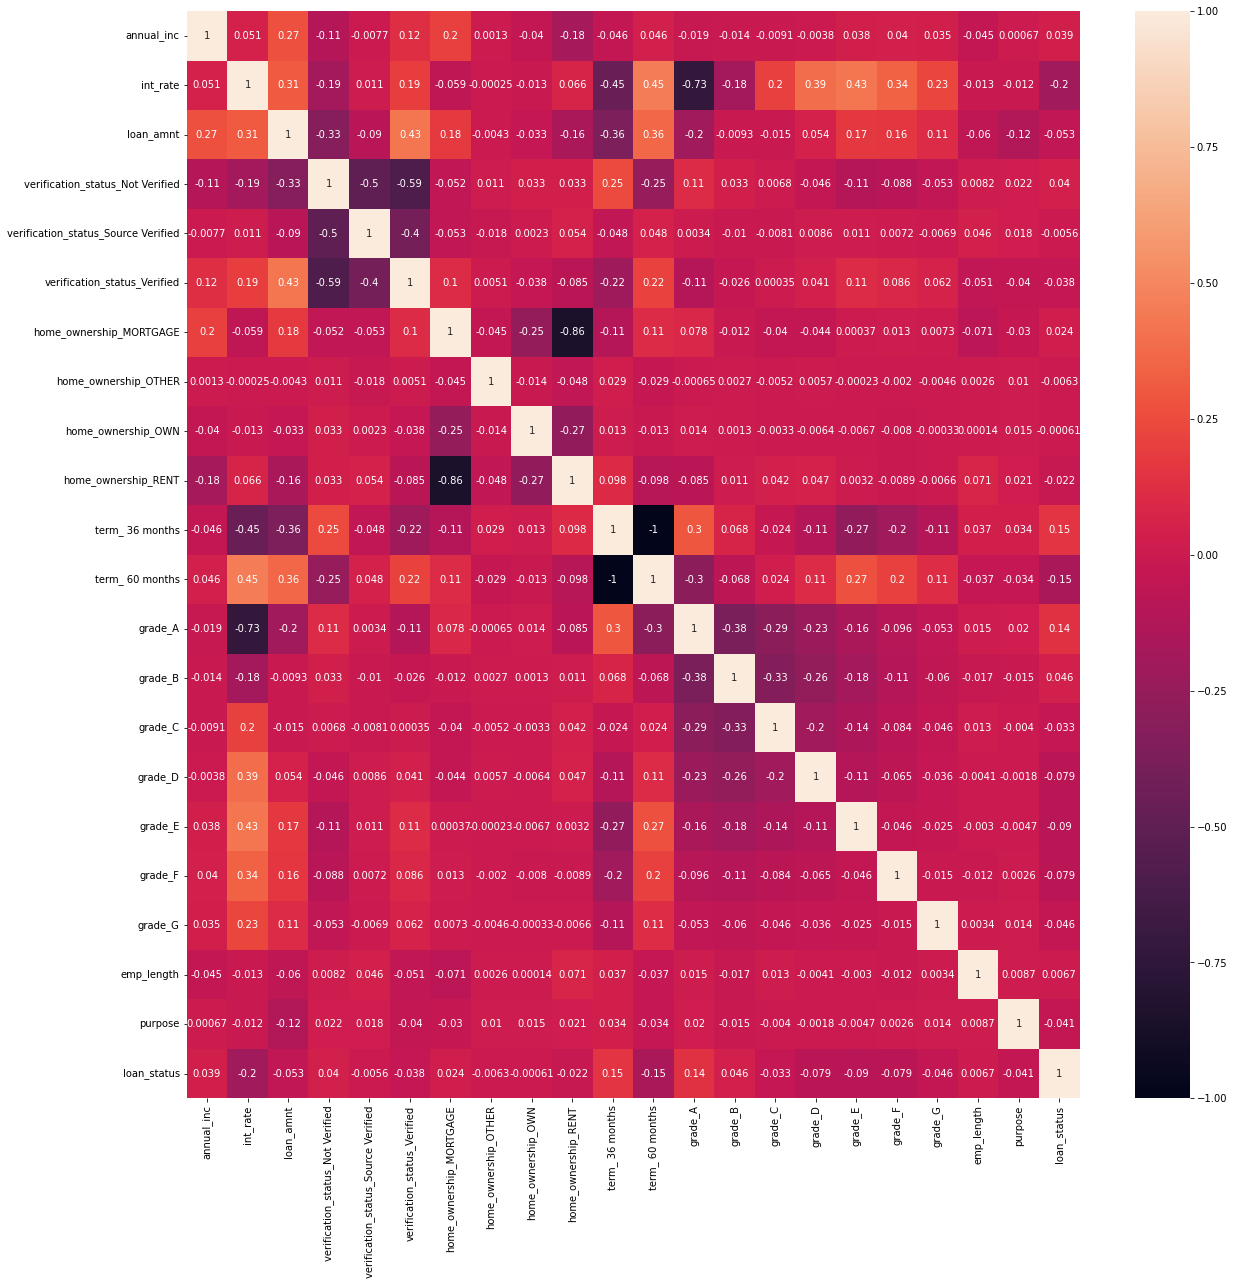

In [ ]:
plt.figure(figsize=(20,20))
sb.heatmap(dataPro.corr(), annot=True)
plt.show()

##Punto A
Como se puede observar en la matriz de correlacion, la variable mas relacionada con el estado del prestamo es la tasa de interes, por lo tanto utilizaremos esa para el modelo de regresion lineal

In [ ]:
XMejor = dataPro[['int_rate']]
y = dataPro[['loan_status']]

In [ ]:
XTrain, XTest, yTrain, yTest = train_test_split(XMejor, y, train_size = 0.75, random_state = 123)
XTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29028 entries, 14400 to 15725
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   int_rate  29028 non-null  float64
dtypes: float64(1)
memory usage: 453.6 KB


In [ ]:
modelLR = LogisticRegression()
modelLR.fit(XTrain, yTrain)
print('beta_0: ', modelLR.intercept_)
print('beta_1: ', list(zip(XMejor.columns, modelLR.coef_.flatten())))

beta_0:  [2.92557778]
beta_1:  [('int_rate', -2.905983029798934)]


In [ ]:
trainPred = modelLR.predict(XTrain)
trainAccuracy = accuracy_score(yTrain, trainPred)
print(f'El desempeño en entrenamiento es {round(trainAccuracy, 3)*100} %')

testPred = modelLR.predict(XTest)
testAcurracy = accuracy_score(yTest, testPred)
print(f'El desempeño en prueba es {round(testAcurracy,3)*100} %')

El desempeño en entrenamiento es 85.9 %
El desempeño en prueba es 86.1 %


<AxesSubplot:>

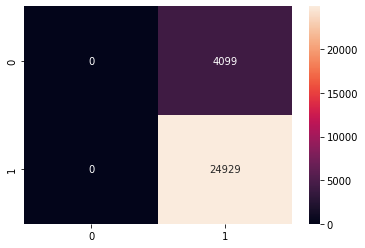

In [ ]:
matrizEntrenamiento = confusion_matrix(yTrain, trainPred)
sb.heatmap(matrizEntrenamiento, annot=True, fmt='d')

<AxesSubplot:>

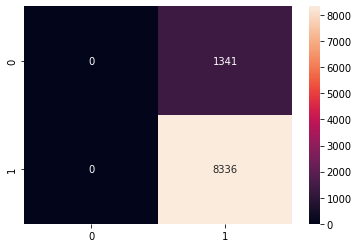

In [ ]:
matrizPrueba = confusion_matrix(yTest, testPred)
sb.heatmap(matrizPrueba, annot=True, fmt='d')

Para arreglar ese resultado tan nefasto que se observa en la matriz de confusion se hara un resampling para dismiuir el desbalance en los datos de salida

###Con Resampling

In [ ]:
# Balanceo de salida
data['loan_status'].value_counts().sort_index()

Charged Off     5440
Fully Paid     33265
Name: loan_status, dtype: int64

Charged Off     5440
Fully Paid     33265
Name: loan_status, dtype: int64

In [ ]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = dataPro[dataPro.loan_status==1]
df_minority = dataPro[dataPro.loan_status==0]
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=33265,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_s = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_s.loan_status.value_counts()
# 1    576
# 0    576
# Name: balance, dtype: int64

1.0    33265
0.0    33265
Name: loan_status, dtype: int64

1.0    33265
0.0    33265
Name: loan_status, dtype: int64

In [ ]:
df_s.shape

(66530, 22)

(66530, 22)

In [ ]:
XMejor = df_s[['int_rate']]
y = df_s[['loan_status']]
XTrain, XTest, yTrain, yTest = train_test_split(XMejor, y, train_size = 0.75, random_state = 123)
XTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49897 entries, 4138 to 18567
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   int_rate  49897 non-null  float64
dtypes: float64(1)
memory usage: 779.6 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 49897 entries, 4138 to 18567
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   int_rate  49897 non-null  float64
dtypes: float64(1)
memory usage: 779.6 KB


In [ ]:
modelLR = LogisticRegression()
modelLR.fit(XTrain, yTrain)
print('beta_0: ', modelLR.intercept_)
print('beta_1: ', list(zip(XMejor.columns, modelLR.coef_.flatten())), "\n")

trainPred = modelLR.predict(XTrain)
trainAccuracy = accuracy_score(yTrain, trainPred)
print(f'El desempeño en entrenamiento es {round(trainAccuracy, 3)*100} %\n')

testPred = modelLR.predict(XTest)
testAcurracy = accuracy_score(yTest, testPred)
print(f'El desempeño en prueba es {round(testAcurracy,3)*100} %')

beta_0:  [1.18903435]
beta_1:  [('int_rate', -3.0785656764251983)] 

El desempeño en entrenamiento es 61.3 %

El desempeño en prueba es 61.1 %
beta_0:  [1.18903435]
beta_1:  [('int_rate', -3.0785656764251983)] 

El desempeño en entrenamiento es 61.3 %

El desempeño en prueba es 61.1 %


<AxesSubplot:>

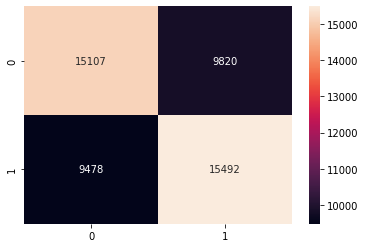

<AxesSubplot:>

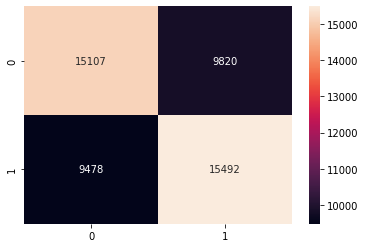

In [ ]:
matrizEntrenamiento = confusion_matrix(yTrain, trainPred)
sb.heatmap(matrizEntrenamiento, annot=True, fmt='d')

<AxesSubplot:>

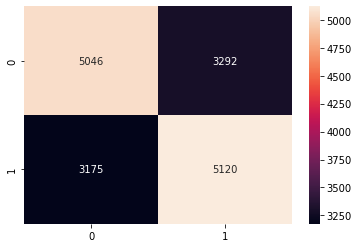

<AxesSubplot:>

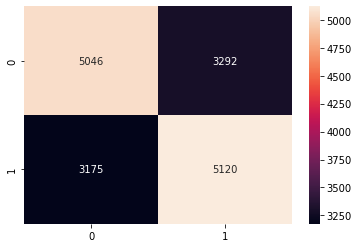

In [ ]:
matrizPrueba = confusion_matrix(yTest, testPred)
sb.heatmap(matrizPrueba, annot=True, fmt='d')

A pesar de los resultados con menor presicion, este modelo es mucho mas util para la empresa de prestamos, ya que el anterior esta completamente sesgado

##Punto B (Teniendo en cuenta todas las variables)

In [ ]:
X = dataPro.drop('loan_status', axis = 1)
y = dataPro[['loan_status']]
XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size = 0.75, random_state = 123)
modelLR2 = LogisticRegression()
modelLR2.fit(XTrain, yTrain)
print('beta_0: ', modelLR2.intercept_)
print('beta_1: ', list(zip(X.columns, modelLR2.coef_.flatten())))

beta_0:  [1.25360161]
beta_1:  [('annual_inc', 1.0685478972680342), ('int_rate', -2.234720823746071), ('loan_amnt', 0.2633053439577627), ('verification_status_Not Verified', 0.3357015538278752), ('verification_status_Source Verified', 0.3696255707756312), ('verification_status_Verified', 0.33767027167751856), ('home_ownership_MORTGAGE', 0.45035970706237993), ('home_ownership_OTHER', -0.07228475545900602), ('home_ownership_OWN', 0.3157356189326518), ('home_ownership_RENT', 0.34918682574499826), ('term_ 36 months', 0.7615768416955905), ('term_ 60 months', 0.28142055458542947), ('grade_A', 0.3705016583103579), ('grade_B', 0.061087984737631454), ('grade_C', 0.029148437308229563), ('grade_D', -0.019879666448925224), ('grade_E', 0.1590894541889142), ('grade_F', 0.1427124987204782), ('grade_G', 0.3003370294643263), ('emp_length', 0.0037540999451619672), ('purpose', -0.03545673194606805)]
beta_0:  [1.25360161]
beta_1:  [('annual_inc', 1.0685478972680342), ('int_rate', -2.234720823746071), ('lo

In [ ]:
dataPro.shape

(38705, 22)

(38705, 22)

In [ ]:
trainPred = modelLR2.predict(XTrain)
trainAccuracyAllVarsLR = accuracy_score(yTrain, trainPred)
print(f'El desempeño en entrenamiento es {round(trainAccuracyAllVarsLR, 3)*100} %\n')

testPred = modelLR2.predict(XTest)
testAcurracy = accuracy_score(yTest, testPred)
print(f'El desempeño en prueba es {round(testAcurracy,3)*100} %')

El desempeño en entrenamiento es 85.9 %

El desempeño en prueba es 86.1 %
El desempeño en entrenamiento es 85.9 %

El desempeño en prueba es 86.1 %


<AxesSubplot:>

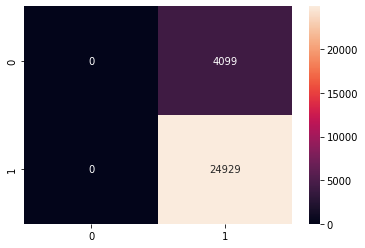

<AxesSubplot:>

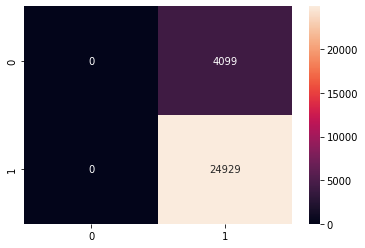

In [ ]:
matrizEntrenamiento = confusion_matrix(yTrain, trainPred)
sb.heatmap(matrizEntrenamiento, annot=True, fmt='d')

<AxesSubplot:>

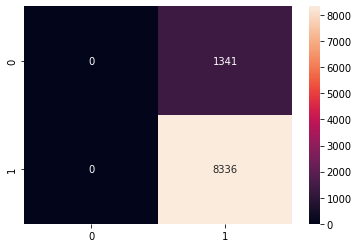

<AxesSubplot:>

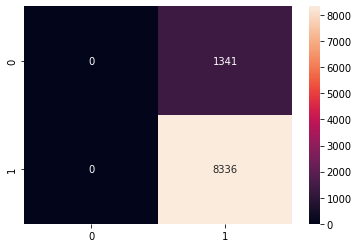

In [ ]:
matrizPrueba = confusion_matrix(yTest, testPred)
sb.heatmap(matrizPrueba, annot=True, fmt='d')

De nuevo el mismo problema de desbalance de datos de salida, veamos como se comporta con el resampling...

###Con Resampling

In [ ]:
X = df_s.drop('loan_status', axis = 1)
y = df_s[['loan_status']]
XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size = 0.75, random_state = 123)
modelLR2 = LogisticRegression()
modelLR2.fit(XTrain, yTrain)
print('beta_0: ', modelLR2.intercept_)
print('beta_1: ', list(zip(X.columns, modelLR2.coef_.flatten())))

beta_0:  [0.38585488]
beta_1:  [('annual_inc', 1.0923223142703802), ('int_rate', -2.611043976016501), ('loan_amnt', 0.25896770617574705), ('verification_status_Not Verified', 0.098602062765139), ('verification_status_Source Verified', 0.15015994999747864), ('verification_status_Verified', 0.12911609192191448), ('home_ownership_MORTGAGE', 0.3324547699797491), ('home_ownership_OTHER', -0.39012711246569476), ('home_ownership_OWN', 0.2213708191479569), ('home_ownership_RENT', 0.21417962802252485), ('term_ 36 months', 0.432966777922163), ('term_ 60 months', -0.05508867323764813), ('grade_A', 0.11331147034662598), ('grade_B', -0.0469827591514804), ('grade_C', -0.09438573996386282), ('grade_D', -0.036792378324736245), ('grade_E', 0.040405236416210646), ('grade_F', 0.10276532657260526), ('grade_G', 0.29955694878912975), ('emp_length', 0.004876236880393359), ('purpose', -0.03584340708431138)]
beta_0:  [0.38585488]
beta_1:  [('annual_inc', 1.0923223142703802), ('int_rate', -2.611043976016501), (

In [ ]:
trainPred = modelLR2.predict(XTrain)
trainAccuracyAllVarsLR = accuracy_score(yTrain, trainPred)
print(f'El desempeño en entrenamiento es {round(trainAccuracyAllVarsLR, 3)*100} %\n')

testPred = modelLR2.predict(XTest)
testAcurracy = accuracy_score(yTest, testPred)
print(f'El desempeño en prueba es {round(testAcurracy,3)*100} %')

El desempeño en entrenamiento es 62.8 %

El desempeño en prueba es 62.6 %
El desempeño en entrenamiento es 62.8 %

El desempeño en prueba es 62.6 %


<AxesSubplot:>

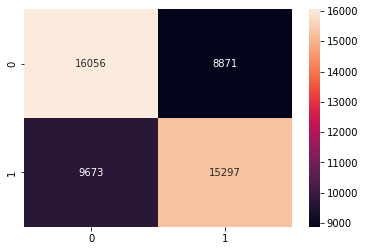

<AxesSubplot:>

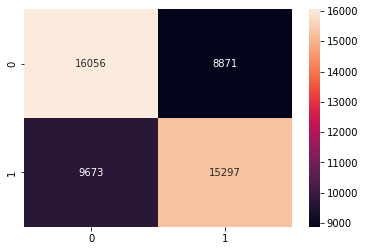

In [ ]:
matrizEntrenamiento = confusion_matrix(yTrain, trainPred)
sb.heatmap(matrizEntrenamiento, annot=True, fmt='d')

<AxesSubplot:>

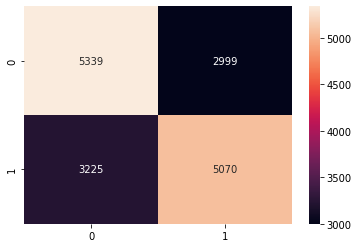

<AxesSubplot:>

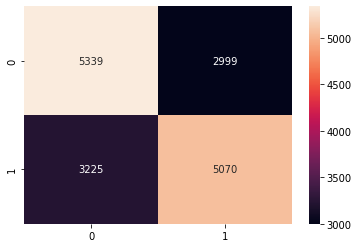

In [ ]:
matrizPrueba = confusion_matrix(yTest, testPred)
sb.heatmap(matrizPrueba, annot=True, fmt='d')

El resultado es muy similar a el del modelo pasado con resampling, con un accuracy bajo, pero sin el sesgo

##Punto C (SVM con las variables que mejoran el modelo
Para este punto las variables que eliminaremos son:
home_ownership_rent y term_60 months ya que 
home_ownership_rent tiene una correlacion de -0.86 con home_ownershipMortage y 
term_36 months tiene una correlacion de -1 con term_60 months.


In [ ]:
#variables a eliminar
elim = ['loan_status','home_ownership_RENT','term_ 60 months']
X = dataPro.drop(elim, axis = 1)
y = dataPro[['loan_status']]
XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size = 0.75, random_state = 123)
modelSVC2 = SVC()
modelSVC2.fit(XTrain, yTrain)

trainPred = modelSVC2.predict(XTrain)
trainAccuracyImpVarsSVC2 = accuracy_score(yTrain, trainPred)
print(f'El desempeño en entrenamiento es {trainAccuracyImpVarsSVC2}')

testPred = modelSVC2.predict(XTest)
testAcurracy = accuracy_score(yTest, testPred)
print(f'El desempeño en prueba es {testAcurracy}')

El desempeño en entrenamiento es 0.85879151164393 %
El desempeño en prueba es 0.8614239950397851 %
El desempeño en entrenamiento es 0.85879151164393 %
El desempeño en prueba es 0.8614239950397851 %


<AxesSubplot:>

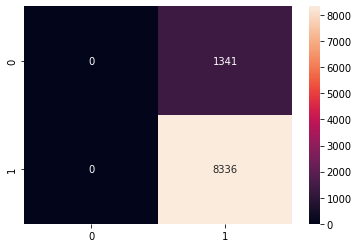

<AxesSubplot:>

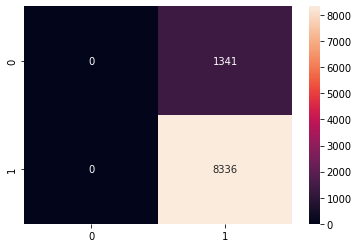

In [ ]:
matrizPrueba = confusion_matrix(yTest, testPred)
sb.heatmap(matrizPrueba, annot=True, fmt='d')

###Con resampling

In [ ]:
#variables a eliminar
elim = ['loan_status','home_ownership_RENT','term_ 60 months']
X = df_s.drop(elim, axis = 1)
y = df_s[['loan_status']]
XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size = 0.75, random_state = 123)
modelSVC2 = SVC()
modelSVC2.fit(XTrain, yTrain)

trainPred = modelSVC2.predict(XTrain)
trainAccuracyImpVarsSVC2 = accuracy_score(yTrain, trainPred)
print(f'El desempeño en entrenamiento es {trainAccuracyImpVarsSVC2}')

testPred = modelSVC2.predict(XTest)
testAcurracy = accuracy_score(yTest, testPred)
print(f'El desempeño en prueba es {testAcurracy}')

El desempeño en entrenamiento es 0.6214602080285387 %
El desempeño en prueba es 0.6221367161666567 %


<AxesSubplot:>

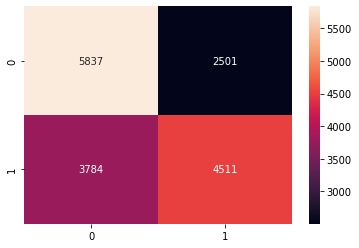

In [ ]:
matrizPrueba = confusion_matrix(yTest, testPred)
sb.heatmap(matrizPrueba, annot=True, fmt='d')

##Punto D (modelo con red neuronal)

In [ ]:
elim = ['loan_status','home_ownership_RENT','term_ 60 months']
X = dataPro.drop(elim, axis = 1)
y = dataPro[['loan_status']]
XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size = 0.75, random_state = 123)

model2 = MLPClassifier(hidden_layer_sizes=(10,10,5),learning_rate_init = 0.001)
model2.fit(XTrain, yTrain)


#Evaluacion
predMLPTrain = model2.predict(XTrain)
predMLPTest = model2.predict(XTest)
accuracyMLPTrain = accuracy_score(yTrain, predMLPTrain)
accuracyMLPTest = accuracy_score(yTest, predMLPTest)
print(f'Train acurracy: {accuracyMLPTrain}')
print(f'Test acurracy: {accuracyMLPTest}')

Train acurracy: 0.8593771530935649 %
Test acurracy: 0.8616306706623954 %


<AxesSubplot:>

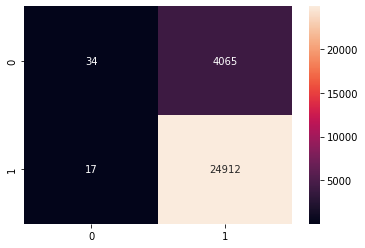

In [ ]:
matrizEntrenamiento = confusion_matrix(yTrain, predMLPTrain)
sb.heatmap(matrizEntrenamiento, annot=True, fmt='d')

###con Resampling

In [ ]:
elim = ['loan_status','home_ownership_RENT','term_ 60 months']
X = df_s.drop(elim, axis = 1)
y = df_s[['loan_status']]

XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size = 0.75, random_state = 123)
model2 = MLPClassifier(hidden_layer_sizes=(10,10,5),learning_rate_init = 0.001)
model2.fit(XTrain, yTrain)


#Evaluacion
predMLPTrain = model2.predict(XTrain)
predMLPTest = model2.predict(XTest)
accuracyMLPTrain = accuracy_score(yTrain, predMLPTrain)
accuracyMLPTest = accuracy_score(yTest, predMLPTest)
print(f'Train acurracy: {accuracyMLPTrain}')
print(f'Test acurracy: {accuracyMLPTest}')

Train acurracy: 0.6457903280758363 %
Test acurracy: 0.6383695064029339 %


<AxesSubplot:>

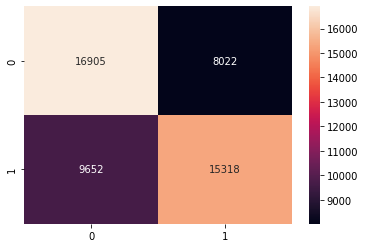

In [ ]:
matrizEntrenamiento = confusion_matrix(yTrain, predMLPTrain)
sb.heatmap(matrizEntrenamiento, annot=True, fmt='d')

<AxesSubplot:>

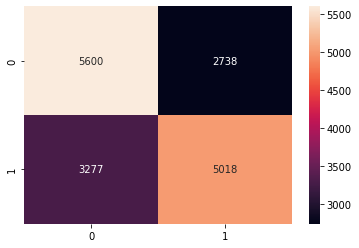

In [ ]:
matrizTest = confusion_matrix(yTest, predMLPTest)
sb.heatmap(matrizTest, annot=True, fmt='d')

##Punto E:
Basados en el resultado entregado por los modelos anteriores, el mejor modelo es el de la red neuronal con resampling, ya que dentro de los modelos que no tienen el sesgo de decir siempre que es de la categoria 1, es el que mejor accuracy presenta.

#Punto 3


Según la matriz de correlación, no es necesario para la empresa verificar la fuente de ingresos de un solicitante de préstamo online antes de aprobar su préstamo. Variando entre 0.004 y -0.0056, se puede concluir que no añaden valor alguno a la predicción de la probabilidad de impago.

Sin embargo, para verificar que tan significante puede ser este dato, haremos el modelo que clasificamos como mejor en el punto anterior, pero sin incluir las variables que describen si los ingresos fueron o no fueron verificados.

In [ ]:
X = df_s.drop(['loan_status', 'verification_status_Not Verified', 'verification_status_Source Verified','verification_status_Verified'], axis = 1)
y = df_s[['loan_status']]
XTrain, XTest, yTrain, yTest = train_test_split(X, y, train_size = 0.75, random_state = 123)

model1 = MLPClassifier(hidden_layer_sizes=(10,10,5),learning_rate_init = 0.001)
model1.fit(XTrain, yTrain)

predMLPTrain = model1.predict(XTrain)
predMLPTest = model1.predict(XTest)
accuracyMLPTrain = accuracy_score(yTrain, predMLPTrain)
accuracyMLPTest = accuracy_score(yTest, predMLPTest)
print(f'Train acurracy MLP: {accuracyMLPTrain}')
print(f'Test acurracy MLP: {accuracyMLPTest}')

Train acurracy MLP: 0.6416417820710664 %
Test acurracy MLP: 0.636505741598028 %


<AxesSubplot:>

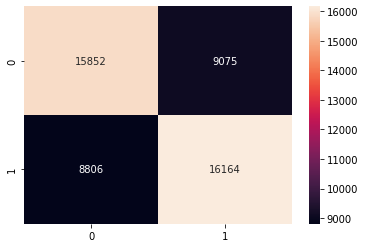

In [ ]:
matrizEntrenamiento = confusion_matrix(yTrain, predMLPTrain)
sb.heatmap(matrizEntrenamiento, annot=True, fmt='d')

<AxesSubplot:>

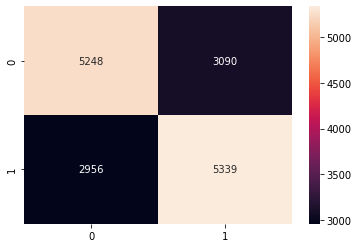

In [ ]:
matrizTest = confusion_matrix(yTest, predMLPTest)
sb.heatmap(matrizTest, annot=True, fmt='d')

Como se pudo observar en este modelo, la variable no es fundamental para lograr este resultado, por lo tanto no es necesario para la empresa verificar los ingresos del cliente